In [1]:
# import packages
import numpy as np
import pandas as pd
import pandasql as ps
import sqlalchemy as sqla
from sqlalchemy import create_engine
import dblogin
import apilogin
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
import pickle

In [2]:
# create engine for executing sql
engine = create_engine(
    "mysql+mysqldb://{}:{}@{}:{}/{}".format(dblogin.USER, dblogin.PASSWORD, dblogin.URI, dblogin.PORT, dblogin.DB),
    echo=True)

In [3]:
# get availability table metadata
metadataA = sqla.MetaData()
# creating table object for availability table
availability = sqla.Table("availability", metadataA,
                          autoload_with=engine,
                          schema='dbikes'
                          )

2023-04-08 17:30:33,378 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2023-04-08 17:30:33,378 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-08 17:30:33,578 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2023-04-08 17:30:33,578 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-08 17:30:33,684 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2023-04-08 17:30:33,684 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-08 17:30:33,988 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `dbikes`.`availability`
2023-04-08 17:30:33,988 INFO sqlalchemy.engine.Engine [raw sql] ()


In [4]:
with engine.begin() as connection:
    avail_df = pd.read_sql_table('availability', connection)

2023-04-08 17:30:35,731 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-08 17:30:35,732 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %s AND table_name = %s
2023-04-08 17:30:35,732 INFO sqlalchemy.engine.Engine [generated in 0.00139s] ('dbikes', 'availability')
2023-04-08 17:30:35,842 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `availability`
2023-04-08 17:30:35,843 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-08 17:30:35,930 INFO sqlalchemy.engine.Engine SELECT availability.number, availability.available_bikes, availability.available_bike_stands, availability.status, availability.last_update 
FROM availability
2023-04-08 17:30:35,930 INFO sqlalchemy.engine.Engine [generated in 0.00088s] ()
2023-04-08 17:30:47,722 INFO sqlalchemy.engine.Engine COMMIT


Import csv data:

In [5]:
# read csv file for historical availability table into pandas dataframe, use parse_dates to convert times to format python likes
#avail_df = pd.read_csv("DB_Backup/availability_202304032122.csv")
#avail_df = pd.read_csv("DB_Backup/availability_202304060936.csv")
avail_df.describe()

,number,available_bikes,available_bike_stands
count,838253.000000,838253.000000,838253.000000
mean,57.958659,11.914955,19.741508
std,33.965842,9.518959,10.861095
min,1.000000,0.000000,0.000000
25%,28.000000,4.000000,12.000000
50%,57.000000,10.000000,20.000000
75%,88.000000,18.000000,28.000000
max,507.000000,40.000000,40.000000


In [6]:
avail_df.head()

,number,available_bikes,available_bike_stands,status,last_update
0,1,26,5,OPEN,2023-02-23 10:29:45
1,1,26,5,OPEN,2023-02-23 10:39:52
2,1,26,5,OPEN,2023-02-23 10:54:18
3,1,24,7,OPEN,2023-02-23 11:02:42
4,1,24,7,OPEN,2023-02-23 11:12:48


In [7]:
station_numbers = avail_df.number.unique()
station_numbers

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 507], dtype=int64)

In [8]:
# get all data for pearse street station
avail_pearse_df = avail_df.loc[avail_df['number'] == 32]
avail_pearse_df.describe()

,number,available_bikes,available_bike_stands
count,8247.0,8247.000000,8247.000000
mean,32.0,13.216685,16.697223
std,0.0,7.597134,7.620079
min,32.0,0.000000,0.000000
25%,32.0,7.000000,11.000000
50%,32.0,13.000000,17.000000
75%,32.0,18.000000,22.000000
max,32.0,30.000000,30.000000


In [9]:
avail_pearse_df.head()

,number,available_bikes,available_bike_stands,status,last_update
232462,32,21,9,OPEN,2023-02-23 10:29:06
232463,32,21,9,OPEN,2023-02-23 10:39:11
232464,32,24,6,OPEN,2023-02-23 10:49:28
232465,32,23,7,OPEN,2023-02-23 10:54:08
232466,32,24,6,OPEN,2023-02-23 10:56:40


In [10]:
avail_pearse_df['last_update'] = pd.to_datetime(avail_pearse_df['last_update'])

C:\Users\danor\AppData\Local\Temp\ipykernel_13616\2801792678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avail_pearse_df['last_update'] = pd.to_datetime(avail_pearse_df['last_update'])


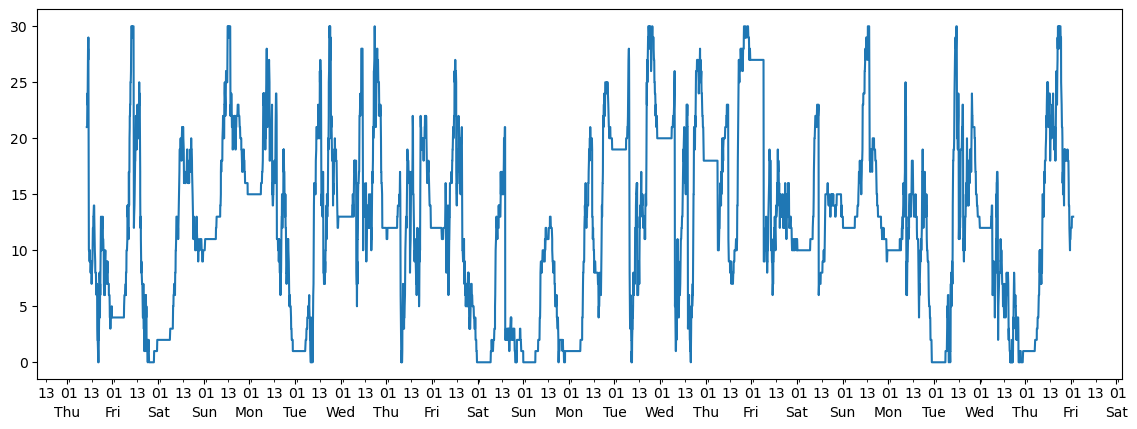

In [11]:
plt.figure().set_figwidth(14)
plt.plot(avail_pearse_df.head(4000)['last_update'], avail_pearse_df.head(4000)['available_bikes'])
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=12))
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('\n%a'))
plt.show()

In [12]:
metadataWH = sqla.MetaData()
# creating table object for weather_historical table
weather_historical = sqla.Table("weather_historical", metadataWH,
                                autoload_with=engine,
                                schema='dbikes'
                                )

2023-04-08 17:31:22,727 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `dbikes`.`weather_historical`
2023-04-08 17:31:22,743 INFO sqlalchemy.engine.Engine [raw sql] ()


In [13]:
with engine.begin() as connection:
    wh_df = pd.read_sql_table('weather_historical', connection)

2023-04-08 17:31:23,156 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-08 17:31:23,158 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %s AND table_name = %s
2023-04-08 17:31:23,160 INFO sqlalchemy.engine.Engine [cached since 47.43s ago] ('dbikes', 'weather_historical')
2023-04-08 17:31:23,257 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `weather_historical`
2023-04-08 17:31:23,258 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-08 17:31:23,362 INFO sqlalchemy.engine.Engine SELECT weather_historical.time, weather_historical.temp, weather_historical.wind_dir, weather_historical.wind_speed, weather_historical.wind_gust, weather_historical.global_rad, weather_historical.humidity, weather_historical.pressure, weather_historical.cloudiness, weather_historical.low_clouds, weather_historical.med_clouds, weather_historical.high_clouds, weather_historical.dew_temp, weather_historical.rain, weather_historical.rain_min, weather_histo

In [14]:
# read csv file for historical wheater table into pandas dataframe, use parse_dates to convert times to format python likes
#wh_df = pd.read_csv("DB_Backup/weather_historical_202304032124.csv")
#wh_df = pd.read_csv("DB_Backup/weather_historical_202304060936.csv")
#wh_df['time'] = pd.to_datetime(wh_df['time'],  format='%Y/%m/%d %H:%M')
wh_df.describe()

,temp,wind_dir,wind_speed,wind_gust,global_rad,humidity,pressure,cloudiness,low_clouds,med_clouds,high_clouds,dew_temp,rain,rain_min,rain_max,rain_prob
count,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000
mean,8.274227,179.291959,4.114021,9.157629,99.288557,75.607732,1009.128351,81.748454,56.300412,31.725567,53.858866,3.972887,0.108557,0.076598,0.181649,14.953402
std,3.255820,91.901845,2.064764,3.941959,149.586321,11.377531,15.532765,31.066795,40.336020,41.693038,45.291692,4.027219,0.287150,0.225282,0.374983,26.610230
min,0.700000,0.700000,0.100000,1.500000,0.000000,30.300000,977.200000,0.000000,0.000000,0.000000,0.000000,-11.300000,0.000000,0.000000,0.000000,0.000000
25%,6.200000,101.300000,2.600000,6.500000,0.000000,69.500000,996.300000,79.325000,11.825000,0.000000,0.000000,1.400000,0.000000,0.000000,0.000000,0.000000
50%,8.400000,198.700000,3.900000,8.600000,3.550000,77.450000,1007.600000,99.700000,63.250000,0.300000,72.550000,4.300000,0.000000,0.000000,0.000000,1.100000
75%,10.900000,255.400000,5.300000,11.700000,166.100000,84.400000,1021.900000,100.000000,99.400000,77.250000,99.700000,7.500000,0.000000,0.000000,0.200000,14.875000
max,15.400000,359.500000,10.700000,23.500000,661.200000,96.800000,1039.400000,100.000000,100.000000,100.000000,100.000000,10.600000,2.800000,2.500000,3.000000,100.000000


In [15]:
avail_pearse_df['time'] = avail_pearse_df['last_update'].dt.ceil('H')

C:\Users\danor\AppData\Local\Temp\ipykernel_13616\1404984998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avail_pearse_df['time'] = avail_pearse_df['last_update'].dt.ceil('H')


In [16]:
merged_df = pd.merge(
    avail_pearse_df,
    wh_df,
    how='right',
    on='time'
)

In [17]:
merged_df.head()

,number,available_bikes,available_bike_stands,status,last_update,time,temp,wind_dir,wind_speed,wind_gust,...,cloudiness,low_clouds,med_clouds,high_clouds,dew_temp,rain,rain_min,rain_max,rain_prob,symbol
0,32.0,28.0,2.0,OPEN,2023-02-23 11:08:17,2023-02-23 12:00:00,8.4,0.8,3.1,7.4,...,0.7,0.7,0.0,0.0,-0.3,0.0,0.0,0.0,0.0,None
1,32.0,27.0,3.0,OPEN,2023-02-23 11:12:19,2023-02-23 12:00:00,8.4,0.8,3.1,7.4,...,0.7,0.7,0.0,0.0,-0.3,0.0,0.0,0.0,0.0,None
2,32.0,29.0,1.0,OPEN,2023-02-23 11:19:23,2023-02-23 12:00:00,8.4,0.8,3.1,7.4,...,0.7,0.7,0.0,0.0,-0.3,0.0,0.0,0.0,0.0,None
3,32.0,20.0,10.0,OPEN,2023-02-23 11:26:30,2023-02-23 12:00:00,8.4,0.8,3.1,7.4,...,0.7,0.7,0.0,0.0,-0.3,0.0,0.0,0.0,0.0,None
4,32.0,11.0,19.0,OPEN,2023-02-23 11:31:52,2023-02-23 12:00:00,8.4,0.8,3.1,7.4,...,0.7,0.7,0.0,0.0,-0.3,0.0,0.0,0.0,0.0,None


In [18]:
merged_df = merged_df[merged_df['last_update'] >= '2023-02-27']

In [19]:
merged_df.head()

,number,available_bikes,available_bike_stands,status,last_update,time,temp,wind_dir,wind_speed,wind_gust,...,cloudiness,low_clouds,med_clouds,high_clouds,dew_temp,rain,rain_min,rain_max,rain_prob,symbol
30,32.0,21.0,6.0,OPEN,2023-02-27 11:06:42,2023-02-27 12:00:00,7.0,96.7,4.3,9.3,...,99.5,99.5,0.0,0.0,0.4,0.0,0.0,0.0,0.0,None
31,32.0,21.0,6.0,OPEN,2023-02-27 11:16:48,2023-02-27 12:00:00,7.0,96.7,4.3,9.3,...,99.5,99.5,0.0,0.0,0.4,0.0,0.0,0.0,0.0,None
32,32.0,21.0,6.0,OPEN,2023-02-27 11:26:54,2023-02-27 12:00:00,7.0,96.7,4.3,9.3,...,99.5,99.5,0.0,0.0,0.4,0.0,0.0,0.0,0.0,None
33,32.0,21.0,6.0,OPEN,2023-02-27 11:37:00,2023-02-27 12:00:00,7.0,96.7,4.3,9.3,...,99.5,99.5,0.0,0.0,0.4,0.0,0.0,0.0,0.0,None
34,32.0,22.0,5.0,OPEN,2023-02-27 11:46:14,2023-02-27 12:00:00,7.0,96.7,4.3,9.3,...,99.5,99.5,0.0,0.0,0.4,0.0,0.0,0.0,0.0,None


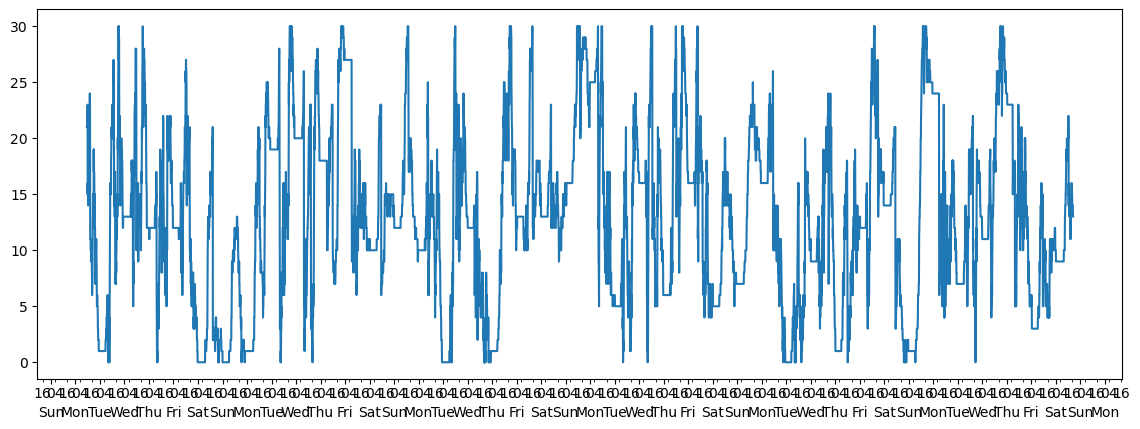

In [20]:
plt.figure().set_figwidth(14)
plt.plot(merged_df['last_update'], merged_df['available_bikes'])
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=12))
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('\n%a'))
plt.show()

In [21]:
drop_cols = ['wind_dir', 'global_rad', 'humidity', 'pressure', 'cloudiness', 'low_clouds', 'med_clouds', 'high_clouds',
            'dew_temp', 'rain_min', 'rain_max', 'symbol', 'available_bike_stands', 'rain_prob', 'time']
merged_df =  merged_df.drop(drop_cols, axis=1)

In [22]:
merged_df.head()

,number,available_bikes,status,last_update,temp,wind_speed,wind_gust,rain
30,32.0,21.0,OPEN,2023-02-27 11:06:42,7.0,4.3,9.3,0.0
31,32.0,21.0,OPEN,2023-02-27 11:16:48,7.0,4.3,9.3,0.0
32,32.0,21.0,OPEN,2023-02-27 11:26:54,7.0,4.3,9.3,0.0
33,32.0,21.0,OPEN,2023-02-27 11:37:00,7.0,4.3,9.3,0.0
34,32.0,22.0,OPEN,2023-02-27 11:46:14,7.0,4.3,9.3,0.0


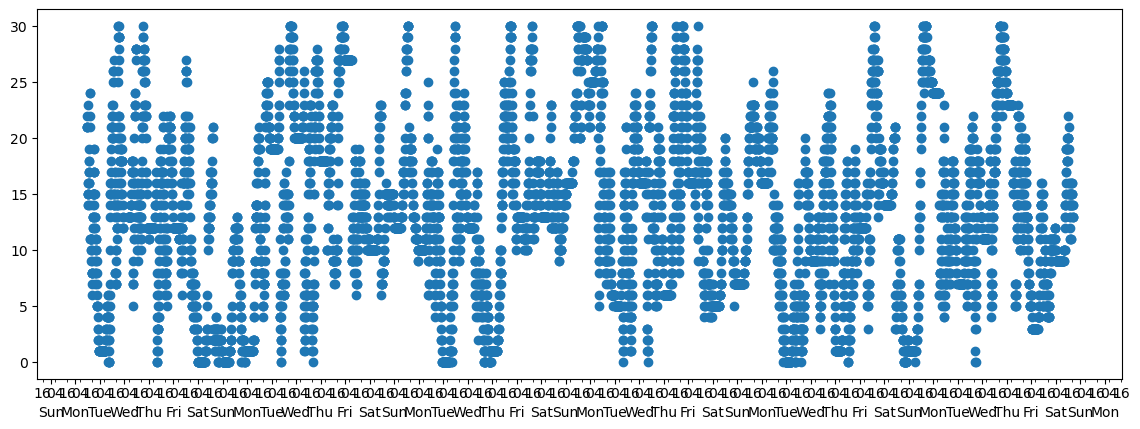

In [23]:
plt.figure().set_figwidth(14)
plt.scatter(merged_df['last_update'], merged_df['available_bikes'])
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=12))
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('\n%a'))
plt.show()

In [24]:
merged_df['weekday'] = merged_df['last_update'].dt.weekday

In [25]:
merged_df['weekday']

30      0
31      0
32      0
33      0
34      0
       ..
7552    5
7553    5
7554    5
7555    5
7556    5
Name: weekday, Length: 7521, dtype: int64

In [26]:
merged_df['workday'] = merged_df['weekday'] < 5

In [27]:
merged_df.to_csv('merged.csv', index=False)

In [28]:
merged_df.head()

,number,available_bikes,status,last_update,temp,wind_speed,wind_gust,rain,weekday,workday
30,32.0,21.0,OPEN,2023-02-27 11:06:42,7.0,4.3,9.3,0.0,0,True
31,32.0,21.0,OPEN,2023-02-27 11:16:48,7.0,4.3,9.3,0.0,0,True
32,32.0,21.0,OPEN,2023-02-27 11:26:54,7.0,4.3,9.3,0.0,0,True
33,32.0,21.0,OPEN,2023-02-27 11:37:00,7.0,4.3,9.3,0.0,0,True
34,32.0,22.0,OPEN,2023-02-27 11:46:14,7.0,4.3,9.3,0.0,0,True


In [29]:
merged_df['last_update']

30     2023-02-27 11:06:42
31     2023-02-27 11:16:48
32     2023-02-27 11:26:54
33     2023-02-27 11:37:00
34     2023-02-27 11:46:14
               ...        
7552   2023-04-08 16:22:19
7553   2023-04-08 16:32:24
7554   2023-04-08 16:37:05
7555   2023-04-08 16:42:31
7556   2023-04-08 16:52:40
Name: last_update, Length: 7521, dtype: datetime64[ns]

In [30]:
# seperate datime into month, day, hour, minute
merged_df['month'] = merged_df['last_update'].dt.month
merged_df['day'] = merged_df['last_update'].dt.day
merged_df['hour'] = merged_df['last_update'].dt.hour
merged_df['minute'] = merged_df['last_update'].dt.minute

In [31]:
# encode workday columns as 0 or 1
#workday = merged_df.workday
#workday = workday.apply(lambda x : 1 if x else 0)
#workday.value_counts()

In [32]:
merged_df.to_csv('merged.csv', index=False)

## Model Creation

In [33]:
features = merged_df

In [34]:
features = features.drop(['number', 'available_bikes', 'status', 'last_update'], axis=1)

In [35]:
features.head()

,temp,wind_speed,wind_gust,rain,weekday,workday,month,day,hour,minute
30,7.0,4.3,9.3,0.0,0,True,2,27,11,6
31,7.0,4.3,9.3,0.0,0,True,2,27,11,16
32,7.0,4.3,9.3,0.0,0,True,2,27,11,26
33,7.0,4.3,9.3,0.0,0,True,2,27,11,37
34,7.0,4.3,9.3,0.0,0,True,2,27,11,46


In [36]:
features['workday']

30       True
31       True
32       True
33       True
34       True
        ...  
7552    False
7553    False
7554    False
7555    False
7556    False
Name: workday, Length: 7521, dtype: bool

In [37]:
features.columns = features.columns.astype(str)

In [38]:
features['workday']

30       True
31       True
32       True
33       True
34       True
        ...  
7552    False
7553    False
7554    False
7555    False
7556    False
Name: workday, Length: 7521, dtype: bool

In [39]:
y = merged_df.available_bikes

In [40]:
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

In [41]:
all_splits = list(ts_cv.split(features, y))
train_0, test_0 = all_splits[0]

In [42]:
features.iloc[test_0]

,temp,wind_speed,wind_gust,rain,weekday,workday,month,day,hour,minute
2555,10.9,7.5,17.3,0.8,0,True,3,13,4,50
2556,10.8,7.1,17.5,0.3,0,True,3,13,5,0
2557,10.8,7.1,17.5,0.3,0,True,3,13,5,10
2558,10.8,7.1,17.5,0.3,0,True,3,13,5,20
2559,10.8,7.1,17.5,0.3,0,True,3,13,5,30
...,...,...,...,...,...,...,...,...,...,...
3550,12.3,4.0,8.0,0.1,5,False,3,18,11,15
3551,12.3,4.0,8.0,0.1,5,False,3,18,11,29
3552,12.3,4.0,8.0,0.1,5,False,3,18,11,38
3553,12.3,4.0,8.0,0.1,5,False,3,18,11,48


In [43]:
features.iloc[train_0]

,temp,wind_speed,wind_gust,rain,weekday,workday,month,day,hour,minute
30,7.0,4.3,9.3,0.0,0,True,2,27,11,6
31,7.0,4.3,9.3,0.0,0,True,2,27,11,16
32,7.0,4.3,9.3,0.0,0,True,2,27,11,26
33,7.0,4.3,9.3,0.0,0,True,2,27,11,37
34,7.0,4.3,9.3,0.0,0,True,2,27,11,46
...,...,...,...,...,...,...,...,...,...,...
2502,11.9,4.8,8.1,0.3,6,False,3,12,20,33
2503,11.9,4.8,8.1,0.3,6,False,3,12,20,44
2504,11.9,4.8,8.1,0.3,6,False,3,12,20,54
2505,11.9,4.8,8.1,0.3,6,False,3,12,20,58


In [44]:
train_4, test_4 = all_splits[2]
features.iloc[test_4]

,temp,wind_speed,wind_gust,rain,weekday,workday,month,day,hour,minute
4555,10.4,3.8,11.9,0.0,3,True,3,23,18,39
4556,10.4,3.8,11.9,0.0,3,True,3,23,18,44
4557,10.4,3.8,11.9,0.0,3,True,3,23,18,52
4558,10.2,6.6,10.4,0.0,3,True,3,23,19,2
4559,10.2,6.6,10.4,0.0,3,True,3,23,19,14
...,...,...,...,...,...,...,...,...,...,...
5551,11.1,4.8,10.5,0.0,2,True,3,29,7,24
5552,11.1,4.8,10.5,0.0,2,True,3,29,7,26
5553,11.1,4.8,10.5,0.0,2,True,3,29,7,30
5554,11.1,4.8,10.5,0.0,2,True,3,29,7,36


In [45]:
features.iloc[train_4]

,temp,wind_speed,wind_gust,rain,weekday,workday,month,day,hour,minute
30,7.0,4.3,9.3,0.0,0,True,2,27,11,6
31,7.0,4.3,9.3,0.0,0,True,2,27,11,16
32,7.0,4.3,9.3,0.0,0,True,2,27,11,26
33,7.0,4.3,9.3,0.0,0,True,2,27,11,37
34,7.0,4.3,9.3,0.0,0,True,2,27,11,46
...,...,...,...,...,...,...,...,...,...,...
4502,13.0,6.3,15.6,0.0,3,True,3,23,13,38
4503,13.0,6.3,15.6,0.0,3,True,3,23,13,44
4504,13.0,6.3,15.6,0.0,3,True,3,23,13,54
4505,13.0,6.3,15.6,0.0,3,True,3,23,13,56


In [46]:
cat_cols = ['workday']
categories = [
    [False, True]
]
ordinal_encoder = OrdinalEncoder(categories=categories)

In [47]:
gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, cat_cols),
        ],
        remainder="passthrough",
        # Use short feature names to make it easier to specify the categorical
        # variables in the HistGradientBoostingRegressor in the next
        # step of the pipeline.
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=cat_cols,
    ),
).set_output(transform="pandas")

In [48]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [49]:
evaluate(gbrt_pipeline, features, y, cv=ts_cv)

Mean Absolute Error:     6.542 +/- 0.671
Root Mean Squared Error: 8.169 +/- 0.796


In [50]:
gbrt_pipeline.fit(features.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt_pipeline.predict(features.iloc[test_0])

In [51]:
gbrt_pipeline.fit(features, y)
gbrt_predictions = gbrt_pipeline.predict(features.iloc[test_0])

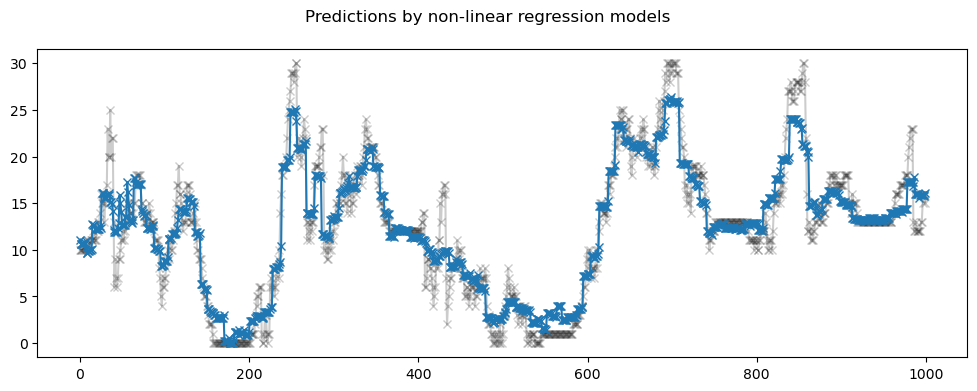

In [52]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by non-linear regression models")
ax.plot(
    y.iloc[test_0].values,
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    gbrt_predictions,
    "x-",
    label="Gradient Boosted Trees",
)

In [53]:
gbrt_predictions = gbrt_pipeline.predict(features)

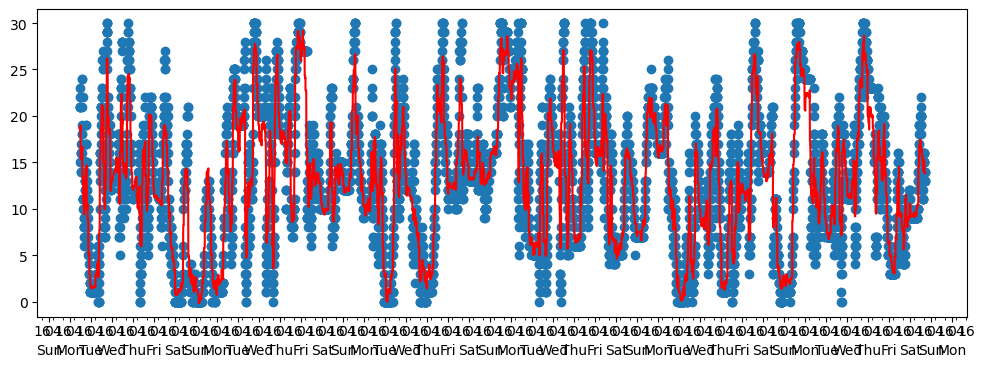

In [54]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(merged_df['last_update'], merged_df['available_bikes'])
ax.plot(merged_df['last_update'], gbrt_predictions, "r-", label="Gradient Boosted Trees")
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=12))
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('\n%a'))
plt.show()

In [55]:
test_prediction = features.tail(1)

In [56]:
test_prediction.head()

,temp,wind_speed,wind_gust,rain,weekday,workday,month,day,hour,minute
7556,12.5,4.8,10.8,0.0,5,False,4,8,16,52


In [57]:
test_prediction_result = gbrt_pipeline.predict(test_prediction)

In [58]:
print(test_prediction_result)

[13.84006351]


In [2]:
d = {
    'temp': [8],
    'wind_speed': [2],
    'wind_gust': [6],
    'rain': [0],
    'weekday': [3],
    'workday': [True],
    'month': [5],
    'day': [2],
    'hour': [23],
    'minute': [0]
}
test_prediction = pd.DataFrame(data=d)

In [5]:
test_prediction['temp'].values[0]

8

In [75]:
test_prediction_result = gbrt_pipeline.predict(test_prediction)
print(test_prediction_result)

[9.35772231]


In [76]:
number = merged_df['number'].values[0]
number

32.0

In [77]:
with open(f"pickle_jar/{number}_model.pkl", 'wb') as handle:
    pickle.dump(gbrt_pipeline, handle, pickle.HIGHEST_PROTOCOL)